# Modern Portfolio Theory: comparison of expected and realized performances

In [1]:
import yfinance as yf

import numpy as np
from numpy.linalg import multi_dot

np.random.seed(42)

import pandas as pd
pd.set_option('display.precision',4)

from datetime import datetime

# Import plotly express for EF plot
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
px.defaults.width, px.defaults.height = 1000,600
pio.templates.default = "plotly_dark"

import cufflinks as cf
cf.set_config_file(offline=True, dimensions=(1000,600),theme='space')

import matplotlib.pyplot as plt

The aim of the present project is to compare the expected returns of different portfolios, assessed using Modern Portfolio Theory, with their realized performance. The analysis focuses on 5 of the major Italian stocks. Historical data from 2011 to 2020 is utilized to determine expected returns and volatility. Successively, portfolios are constructed at the beginning of 2021, using prior knowledge to forecast their performances. Finally, historical data from 2021 to the present day is used to benchmark the results of the analysis.



## Data analysis
The adjusted closing price starting from 2011 is retrieved through Yahoo Finance.

In [2]:
assets = ['STMMI','LDO','TRN','UCG','ENI']
assets.sort()

# Get yahoo tickers
yahooticker = [x+'.MI' for x in assets]

# Fetch data
df = yf.download(yahooticker,start='2011-01-01')['Adj Close']

# Visualize pandas dataframe relative to year 2020
df['2020':'2020']

[*********************100%***********************]  5 of 5 completed


,ENI.MI,LDO.MI,STMMI.MI,TRN.MI,UCG.MI
Date,,,,,
2020-01-02,11.0954,9.9732,24.1750,5.1026,10.8245
2020-01-03,11.1730,10.0732,24.0090,5.0836,10.6961
2020-01-06,11.3393,10.3541,23.4622,5.0371,10.4986
2020-01-07,11.3425,10.4921,24.0578,5.0733,10.5612
2020-01-08,11.2522,10.8063,24.0383,5.1284,10.6961
...,...,...,...,...,...
2020-12-22,7.0888,5.5984,29.7070,5.4865,6.6485
2020-12-23,7.2788,5.7229,29.8546,5.5241,6.7970
2020-12-28,7.2889,5.7638,29.9334,5.6245,6.8032


In [3]:
# Plot price history
df.iplot(kind='line')

Daily returns are computed based on the retrieved data, and then used to evaluate annualized returns and volatility for the whole timespan. The number of trading days is required for scaling daily statistics to their annualized corresponding value. The count here is based on the UK trading calendar ($365 \ \text{days} - 52*2 \ \text{weekend days} - 8\  \text{bank holidays}$). However the trading calendar for the Italian Stock market is different and does not have a fixed number of trading days across different years.

In [4]:
# Number of samples per year
tradingDaysPerYear = 252
# Daily returns
returns = df.pct_change().dropna()
# Annualized statistics
annualReturns = returns.mean()*tradingDaysPerYear
annualVolatility = returns.std()*np.sqrt(tradingDaysPerYear)

# Collecting data in a dataframe
market_statistics = pd.DataFrame({
    'Average annual return': annualReturns,
    'Average annual volatility': annualVolatility
})
market_statistics

,Average annual return,Average annual volatility
ENI.MI,0.0889,0.2737
LDO.MI,0.1259,0.4022
STMMI.MI,0.2467,0.3971
TRN.MI,0.1403,0.2152
UCG.MI,0.0698,0.4620


In [5]:
# Correlation matrix
returns.corr().iplot(kind='heatmap',colorscale='Blues')


As the objective of the project is to build a portfolio using historical data and to benchmark its realized returns against their expected performance, the portfolio is built on the first trading day of 2021 using data spanning from 2011 to 2020, assuming no knowledge about future prices. The expected performance of the portfolio is evaluated through Monte Carlo simulation and it is finally compared to the realized performance.

In [6]:
# Compute returns and volatility using data from 2011 to 2020
yearStart = '2011'
yearEnd = '2020'
partial_returns = df[yearStart:yearEnd].pct_change().dropna()
partial_annualReturns = partial_returns.mean()*tradingDaysPerYear
partial_annualVolatility = partial_returns.std()*np.sqrt(tradingDaysPerYear)

partial_statistics = pd.DataFrame({
    'Average annual return': partial_annualReturns,
    'Average annual volatility': partial_annualVolatility
})
partial_statistics

,Average annual return,Average annual volatility
ENI.MI,0.0348,0.2782
LDO.MI,0.0622,0.4203
STMMI.MI,0.2600,0.4089
TRN.MI,0.1418,0.2170
UCG.MI,-0.0519,0.4771


A first forecast of the outcome of this analysis can be drawn by looking at the realized returns and comparing them to the historical data. 

In [7]:
# Compute realized returns between 2021 and 2023
yearStart = '2021'
yearEnd = '2023'
realized_returns = df[yearStart:yearEnd].pct_change().dropna()
realized_annualReturns = realized_returns.mean()*tradingDaysPerYear
realized_annualVolatility = realized_returns.std()*np.sqrt(tradingDaysPerYear)

realized_statistics = pd.DataFrame({
    'Average annual return': realized_annualReturns,
    'Average annual volatility': realized_annualVolatility
})

# Concatenate the two previous dataframes
comparison_df = pd.concat([partial_statistics, realized_statistics] ,axis=1, keys=['Historical data', 'Realized data'])
comparison_df

Historical data                            \
         Average annual return Average annual volatility   
ENI.MI                  0.0348                    0.2782   
LDO.MI                  0.0622                    0.4203   
STMMI.MI                0.2600                    0.4089   
TRN.MI                  0.1418                    0.2170   
UCG.MI                 -0.0519                    0.4771   

                 Realized data                            
         Average annual return Average annual volatility  
ENI.MI                  0.2946                    0.2562  
LDO.MI                  0.3682                    0.3263  
STMMI.MI                0.1837                    0.3497  
TRN.MI                  0.1360                    0.2089  
UCG.MI                  0.5257                    0.4003

In [8]:
# Compare historical and realized data with bar plots
comparison_df.loc[:,(slice(None),'Average annual return')].iplot(kind='bar',title='Historical vs realized returns')
comparison_df.loc[:,(slice(None),'Average annual volatility')].iplot(kind='bar',title='Historical vs realized volatility')

In [9]:
# Compare the normalized stock prices
df['2021':].normalize().iplot()

The Italian stock market deviated from the trends showed in the previous 10 years. ENI, Leonardo and Unicredit Group delivered higher returns than expected, due to specific circumstances such as the energetic crisis, Russian invasion of Ukraine and raising interest rates. Conversely, STMicroelectronics performed worse than expected. However, volatility in these stock prices remained substantially consistent. Therefore the analysis on the portfolio performance will be more meaningful when comparing expected and realized volatility, while realized returns will deviate significantly.

## Portfolio generation

Modern portfolio theory makes use of the $(\mu - \sigma)$ plane to visualize the tradeoff between risk and return for various allocations on the desired assets. The admissible region in the plane is also called *Markowitz bullet*. Rather than determining such region analytically, the following cell implements a function for generating a desired number of portfolios with randomly assigned weights.

In [10]:
def portfolio_MCgeneration(returns, numPortfolios,short=False):
    # Number of assets in the market
    numAssets = len(returns.columns)

    # Initialize the lists
    rets, vols, wts = [],[],[]

    # Simulate portfolios
    for i in range(numPortfolios):

        # Generate random weights (between -1 and 1 if short selling is allowed, between 0 and 1 otherwise)
        weights = 2*np.random.random(numAssets)-1 if short else np.random.random(numAssets)

        # Normalize to 1 the sum of the weights
        weights /= np.sum(weights)

        # Portfolio statistics
        rets.append(weights.T @ np.array(returns.mean()*tradingDaysPerYear))
        vols.append(np.sqrt(multi_dot([weights.T,returns.cov()*tradingDaysPerYear,weights])))
        wts.append(weights)
        
    # Create a dataframe for analysis
    data = {'port_rets': rets, 'port_vols': vols}
    for counter, symbol in enumerate(returns.columns.to_list()):
        data[symbol+' weight'] = [w[counter] for w in wts]

    portdf = pd.DataFrame(data)

    # Compute sharpe ratio (assuming zero risk-free rate)
    portdf['sharpe_ratio'] = portdf['port_rets']/portdf['port_vols']

    return round(portdf,4)

In [11]:
# Number of portfolios
numPortfolios = 10000

# Generate portfolios with random weights
portfolioSamples = portfolio_MCgeneration(partial_returns, numPortfolios)
portfolioSamples.head()

,port_rets,port_vols,ENI.MI weight,LDO.MI weight,STMMI.MI weight,TRN.MI weight,UCG.MI weight,sharpe_ratio
0,0.1206,0.2791,0.1332,0.3381,0.2603,0.2129,0.0555,0.4323
1,0.1183,0.2936,0.0653,0.0243,0.3625,0.2516,0.2963,0.4029
2,0.1344,0.3226,0.0093,0.4375,0.3755,0.0958,0.0820,0.4168
3,0.1198,0.2754,0.1057,0.1753,0.3024,0.2489,0.1678,0.4348
4,0.0719,0.2716,0.3279,0.0748,0.1566,0.1963,0.2444,0.2647


In [12]:
# Plot portfolios in mu-sigma plane
fig = px.scatter(
    portfolioSamples, x='port_vols', y='port_rets', color='sharpe_ratio',
    labels={'port_vols': 'Standard deviation', 'port_rets': 'Expected return',
            'sharpe_ratio': 'Sharpe Ratio'},
            title='Monte Carlo generated portfolios'
).update_traces(mode='markers',marker=dict(symbol='cross'))

# Plot max sharpe
fig.add_scatter(
    mode='markers',
    x=[portfolioSamples.iloc[portfolioSamples.sharpe_ratio.idxmax()]['port_vols']],
    y=[portfolioSamples.iloc[portfolioSamples.sharpe_ratio.idxmax()]['port_rets']],
    marker=dict(color='RoyalBlue', size=20, symbol='star'),
    name = 'Max Sharpe',
).update(layout_showlegend=False)

fig.add_scatter(
    x=partial_statistics["Average annual volatility"],
    y=partial_statistics["Average annual return"],
    text = [f'Asset: {index}<br>Standard deviation: {vol:.2f}<br>Expected return: {ret:.2f}' 
            for index, vol, ret in zip(partial_statistics.index, partial_statistics["Average annual volatility"], partial_statistics["Average annual return"])],
    hoverinfo='text',
    mode='markers',
    marker=dict(color='green', size=8),
)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

The plot shows the admissible region, delimited by the hyperbola representing the minimum variance line. Sharpe Ratio is also displayed and it is computed assuming zero risk-free interest rate.

In [13]:
# Format the plot and save it as html file
fig.update_xaxes(spikecolor="black"), fig.update_yaxes(spikecolor="black")
fig.update_layout(template="plotly_white",)
fig.write_html("markowitz.html")

### Portfolio selection
Supposing that the investor desires a return close to $0.15$, the randomly generated portfolios having an expected returns close to such values are selected.

In [14]:
desiredReturn = 0.15
return_lowerBound, return_upperBound = desiredReturn - 0.001, desiredReturn + 0.001
portfolioSamples[(portfolioSamples['port_rets']>return_lowerBound) & (portfolioSamples['port_rets']<=return_upperBound)].head()


,port_rets,port_vols,ENI.MI weight,LDO.MI weight,STMMI.MI weight,TRN.MI weight,UCG.MI weight,sharpe_ratio
21,0.1505,0.2946,0.1449,0.2385,0.4390,0.1329,0.0447,0.5110
484,0.1503,0.2834,0.0948,0.0138,0.4482,0.2717,0.1714,0.5303
582,0.1501,0.2477,0.1071,0.0007,0.3389,0.4492,0.1042,0.6063
903,0.1498,0.2960,0.1993,0.2551,0.4386,0.0960,0.0110,0.5062
976,0.1498,0.3047,0.1157,0.2659,0.4540,0.1021,0.0623,0.4917


Each of the selected portfolio has a different level of risk. The extreme cases are here selected to proceed with the comparison.

In [15]:
# Selecting the minimum risk portfolio
index_minVol = portfolioSamples[(portfolioSamples['port_rets']>return_lowerBound) & (portfolioSamples['port_rets']<=return_upperBound)].port_vols.idxmin()
# Selecting the maximum risk portfolio
index_maxVol = portfolioSamples[(portfolioSamples['port_rets']>return_lowerBound) & (portfolioSamples['port_rets']<=return_upperBound)].port_vols.idxmax()

indices = [index_minVol, index_maxVol,]
# Display the portfolios statistics
selectedPortfolios = portfolioSamples.loc[indices,['port_vols','port_rets']]
selectedPortfolios

,port_vols,port_rets
6959,0.2441,0.1491
9933,0.3433,0.1508


The weights relative to the minimum and maximum variance portfolios are stored in the list `weights_set`.

In [16]:
# Select columns containing weights
columns_weights = [x+' weight' for x in yahooticker]
# Retrieving weights from the dataframe containing randomly generated portfolios
weights_set = [portfolioSamples.iloc[index][columns_weights].to_numpy() for index in indices]

### Monte Carlo simulation
The expected performance of the portfolios is evaluated through Monte Carlo simulation.

In [17]:
def simulateStock_MC(stock, source, stats, nSims, start, end='today'):
    # Retrieve initial stock price
    S0 = source.loc[start][stock]

    # Retrieve expected return and stdev
    mu = stats.loc[stock]['Average annual return']
    sigma = stats.loc[stock]['Average annual volatility']

    # Determine end date
    end_date = datetime.today().strftime('%Y-%m-%d') if (end == 'today') else end

    # Count busines days in between
    nDays = np.busday_count(start, end_date)
    
    # Timestep size (fraction of year)
    dt = 1 / tradingDaysPerYear

    S = np.zeros((nDays,nSims))
    S[0] = S0

    for i in range(nDays-1):
        w = np.random.standard_normal(nSims)
        S[i+1] = S[i]*(1 + mu*dt + sigma*np.sqrt(dt)*w)

    simulatedPaths = pd.DataFrame(S)
    return simulatedPaths
    

def simulatePortfolio_MC(source,stats,weights, initialWealth,nSims,start,end='today'):
    # Simulate each stock
    dfs = [simulateStock_MC(stock, source, stats, nSims, start, end) for stock in source.columns]
    # Compute number of shares
    nShares = weights*initialWealth/source.loc[start].to_numpy()
    # Compute portfolio values
    simulatedPortfolio = sum(dfs[i]*nShares[i] for i in range(len(weights)))
    return simulatedPortfolio


In [18]:
initialWealth = 100
nSims = 10000
start_date = '2021-01-04'

portfolio1_simulation = simulatePortfolio_MC(df,partial_statistics,weights_set[0],initialWealth, nSims, start_date)
portfolio2_simulation = simulatePortfolio_MC(df,partial_statistics,weights_set[1],initialWealth, nSims, start_date)

The following figures show the distribution of today's simulated portfolio values.

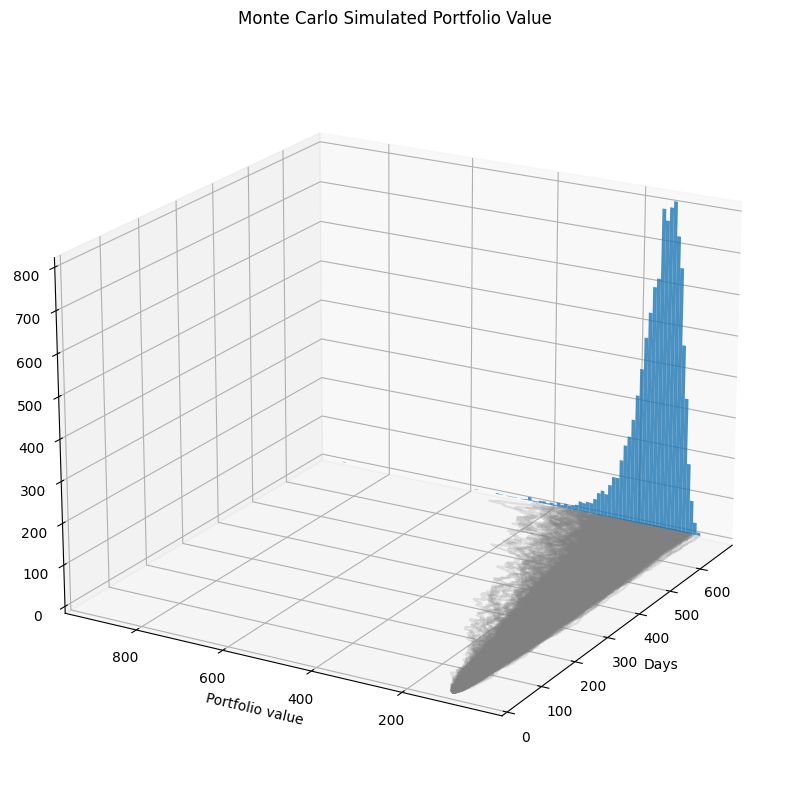

In [19]:
nDays = len(portfolio1_simulation)

ax = plt.figure(figsize=(15,10)).add_subplot(projection='3d')
# Plot 2000 simulated paths on the xy-plane
ax.plot(range(nDays),portfolio1_simulation.iloc[:,:2000], zs=0, zdir='z', alpha=0.2, color = 'gray')
# Plot histogram of expected final values
hist, edges = np.histogram(portfolio1_simulation.iloc[-1,:], bins = 100)
xpos = (edges[:-1] + edges[1:]) / 2
ax.bar(xpos, hist, zs=nDays, zdir='x', width=np.diff(edges)[0], alpha=0.8)
# Format the figure
plt.xlabel('Days')
plt.xlim(0,nDays)
plt.ylabel('Portfolio value')
plt.title('Monte Carlo Simulated Portfolio Value')
plt.grid()
ax.set_xlim(0)
ax.set_zlim(0)
ax.view_init(elev=20,azim=210)

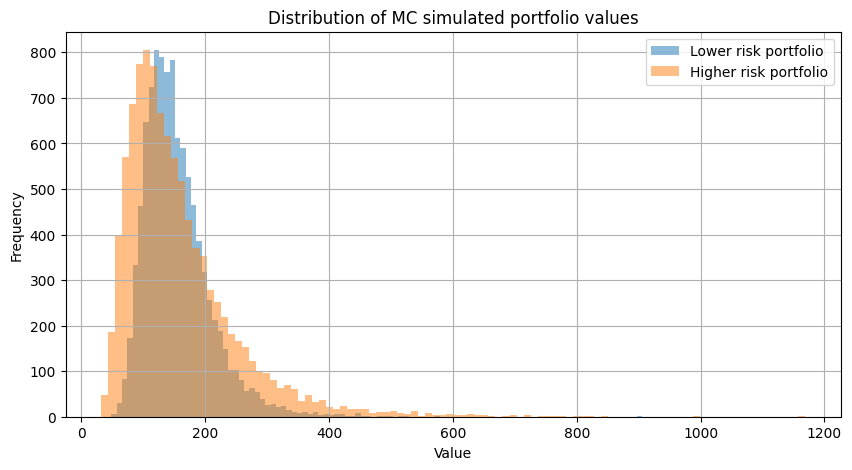

In [20]:
plt.figure(figsize=(10, 5))

# Plot the first histogram
plt.hist(portfolio1_simulation.iloc[-1], bins=100, alpha=0.5, label='Lower risk portfolio')

# Plot the second histogram
plt.hist(portfolio2_simulation.iloc[-1], bins=100, alpha=0.5, label='Higher risk portfolio')

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of MC simulated portfolio values')

# Show the combined histogram
plt.grid()
plt.show()

The last histogram shows the log-normal disribution of the portfolio values.

### Realized performance

The following cell defines a a list of functions to evaluate the realized performance of one or more portfolios.

In [21]:
def evaluateStock(stock,source,start,end = 'today'):
    end_date = datetime.today().strftime('%Y-%m-%d') if (end == 'today') else end
    return source.loc[start:end_date,stock]

def evaluateMarket(source,start,end = 'today'):
    return pd.DataFrame({stock: evaluateStock(stock, source, start, end) for stock in source.columns})

def evaluatePortfolio(source, weights, initialWealth, start, end = 'today'):
    stockPrices = evaluateMarket(source,start,end)
    nShares = weights*initialWealth/stockPrices.iloc[0].to_numpy()
    portfolio_df = pd.DataFrame({
        'Date': stockPrices.index,
        'portfolioValue': np.dot(stockPrices.to_numpy(), nShares)
    })
    portfolio_df.set_index('Date',inplace=True)
    return portfolio_df
    
def evaluateMultiplePortfolios(source,weights_set, initialWealth, start, end = 'today'):
    dfs = [evaluatePortfolio(source, wts, initialWealth, start, end) for wts in weights_set]
    df = pd.DataFrame({'Portfolio_'+str(i+1): dfs[i]['portfolioValue'] for i in range(len(dfs))})
    return df

In [22]:
realizedPortfolios = evaluateMultiplePortfolios(df,weights_set, initialWealth, start_date)
realizedPortfolios.iplot()

In [23]:
realizedPortfolios.iplot(asUrl = True, filename = 'realized_portfolios',theme='polar');

The two portfolios are supposed to have the same expected return, but very different level of risk. It is evident that the first portfolio has a lower volatility than the second one, as it was expected from both the historical data and the realized statistics. The next plots show the comparison between expected and realized returns and volatilities.

In [24]:
realizedReturn = realizedPortfolios.pct_change().dropna().mean()*tradingDaysPerYear
realizedVolatility = realizedPortfolios.pct_change().dropna().std()*np.sqrt(tradingDaysPerYear)
portfolio_stats = pd.DataFrame({'Realized annual volatility': realizedVolatility, 'Realized annual return': realizedReturn,})
portfolio_stats

,Realized annual volatility,Realized annual return
Portfolio_1,0.1857,0.2034
Portfolio_2,0.2732,0.2909


In [25]:
column_dict = {'port_rets':'Expected return','port_vols':'Expected volatility'}
index_dict = {index: new for index, new in zip(selectedPortfolios.index,portfolio_stats.index)}

comparison_table = portfolio_stats.join(selectedPortfolios.rename(columns=column_dict,index=index_dict))
comparison_table[['Expected return', 'Realized annual return']].iplot(kind='bar',title='Returns')
comparison_table[['Expected volatility', 'Realized annual volatility']].iplot(kind='bar',title='Volatility')

The second portfolio outperformed the first one in terms of realized returns. However, choosing such portfolio comes with higher risk. The last plot shows that the distribution for the final value of the higher risk portfolio has fatter tails. This imply a higher likelihood to observe values that deviate significantly from the expected final portfolio value.

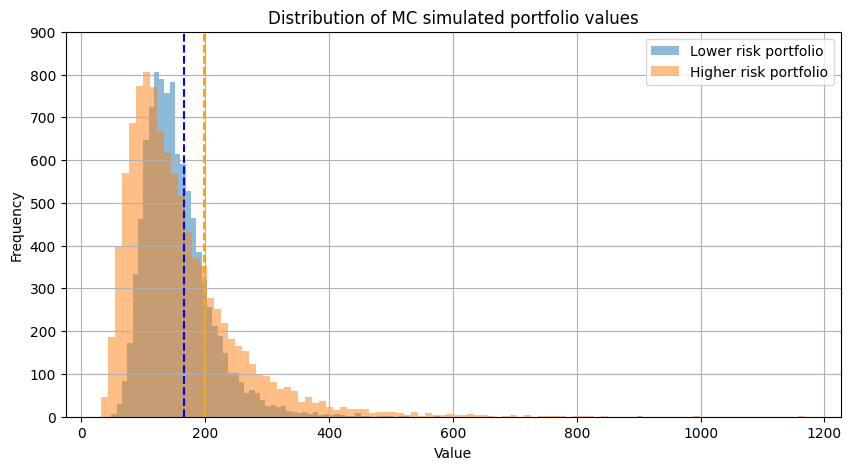

In [26]:
plt.figure(figsize=(10, 5))

# Plot the first histogram
plt.hist(portfolio1_simulation.iloc[-1], bins=100, alpha=0.5, label='Lower risk portfolio')

# Plot the second histogram
plt.hist(portfolio2_simulation.iloc[-1], bins=100, alpha=0.5, label='Higher risk portfolio')

plt.vlines(realizedPortfolios.iloc[-1,0], 0, 1000, colors='blue',linestyles='dashed')
plt.vlines(realizedPortfolios.iloc[-1,1], 0, 1000, colors='orange',linestyles='dashed')
# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.ylim([0,900])
plt.legend()
plt.title('Distribution of MC simulated portfolio values')

# Show the combined histogram
plt.grid()
plt.show()

